In [1]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pytz
import itertools
from statsmodels.formula.api import ols
from loguru import logger
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [45]:
class Pacing:
    """ The pacing algorithm class
    """

    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date + timedelta(days=1))
        self.total_days = (self.end_date - self.start_date).days
        # Initialize variables for the first day
        self.budget_objective = total_budget
        self.budget_engaged = 0
        self.budget_spent_total = 0
        self.budget_remaining = self.budget_objective - (
                self.budget_engaged + self.budget_spent_total)
        self.building = list()
        self.building_data = pd.DataFrame.from_records(self.building)
        self.remaining_days = (self.end_date - self.start_date).days
        self.current_hour = -1
        self.budget_remaining_hourly = 0
        self.budget_daily = self.budget_remaining / self.remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.ongoing_br = {}
        self.acceleration = [{'ts': self.start_date,
                              'A': 0}]
        self.speed = [{'ts': self.start_date,
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)
        # Setup variables to begin pacing
        self.day = self.start_date.day
        self.nb_br = 0
        self.nb_buy = 0
        self.prop_purchase = 0
        self.spent_per_sec = 0
        self.new_objective = None
        self.trigger_count = False
        self.surplus_hour = 0
        self.spent_hour = 0
        self.block_increase = False
        self.first_br = True
        self.first_day = True

    @staticmethod
    def gen_prop_lr(br_object):
        """Linear regression with hours and weekdays"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
        aggr.index.names = ['date', 'weekday', 'hour']
        aggr = aggr.reset_index()
        model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
        weekday_list = range(7)
        weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
        hour_list = list()
        for i in range(7):
            for z in range(24):
                hour_list.append(z)
        df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
        line, col = pattern.shape
        for i in range(col):
            pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
        return pattern

    @staticmethod
    def gen_prop_lr_hour(br_object):
        """Linear regression with only hours"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
        aggr.columns = ['date', 'hour', 'imps']
        model = ols('imps ~ C(hour)', data=aggr).fit()
        hour_list = list()
        for z in range(24):
            hour_list.append(z)
        df_fitting = pd.DataFrame({'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        df_fitting.index = df_fitting.hour
        del df_fitting['hour']
        df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
        return df_fitting

    def meta_prop(self, data):
        """ Give the proportion of impressions per hour. The output type depends on the input.

        :param data: a dataframe with a datetime as index
        :return: an  integer, a Serie or a Dataframe
        """
        if data.empty:
            unif = True
            without_weekday = True
            prop = 1 / 24
        elif set(data.index.hour.unique()) != set(range(24)):
            unif = True
            without_weekday = True
            prop = 1 / 24
        else:
            if set(data.index.weekday.unique()) != set(range(7)):
                unif = False
                without_weekday = True
                prop = self.gen_prop_lr_hour(data)
            else:
                unif = False
                without_weekday = False
                prop = self.gen_prop_lr(data)
        return prop, unif, without_weekday

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        self.remaining_days = (self.end_date - ts).days + 1  # +1 because biased calculation of days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.first_day = False
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.budget_remaining_hourly = 0
        self.budget_daily = self.budget_remaining / self.remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.budget_remaining_hourly / self.remaining_hours
        if self.unif:
            self.budget_hour = (self.prop_table * self.budget_daily) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.budget_daily + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.budget_daily + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        alpha = average_acceleration * coef
        try:
            bt = self.budget_remaining_hourly * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps, br_id):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        if self.first_br:
            self.first_br = False
            self.ts_first_br = datetime.timestamp(ts)

            # Enough time to check proportion
        if datetime.timestamp(ts) - self.ts_first_br >= 3600:
            self.trigger_count = True

        # TS de la BR
        self.weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(self.weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        self.bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(self.bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        self.size_speed += 1
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})
        self.size_acceleration += 1

        # Buying decision
        if (self.bt >= self.target) and (self.budget_remaining_hourly - price) >= 0:
            buying = True
            self.budget_engaged += price
            self.spent_hour += price
            self.nb_buy += 1
            self.ongoing_br[br_id] = price
        else:
            buying = False
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour
        self.budget_remaining = self.budget_objective - (
                self.budget_engaged + self.budget_spent_total)
        if self.budget_remaining < 0:
            self.budget_remaining = 0
        self.nb_br += 1

        # Check proportion of bought br
        self.new_objective = self.check_proportion(ts)

        return buying

    def check_proportion(self, ts):
        self.prop_purchase = self.nb_buy / self.nb_br
        if not self.first_day and self.trigger_count and self.prop_purchase >= 0.7:
            elapsed_time = datetime.timestamp(ts) - datetime.timestamp(self.start_date)
            spent_per_sec = self.budget_spent_total / elapsed_time
            remaining_time = datetime.timestamp(self.end_date) - datetime.timestamp(ts)
            new_objective = (spent_per_sec * remaining_time) * 0.85
            if (self.budget_spent_total + self.budget_engaged) < new_objective < self.budget_objective:
                self.block_increase = True
                self.trigger_count = False
                self.ts_first_br = datetime.timestamp(ts)
                return new_objective

    def reallocate_budget(self, new_objective):
        self.budget_objective = new_objective
        self.budget_remaining = self.budget_objective - (
                self.budget_engaged + self.budget_spent_total)
        self.budget_daily = self.budget_remaining / self.remaining_days
        if self.unif:
            self.budget_hour = (self.prop_table * self.budget_daily) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.budget_daily + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, self.weekday] / 100) * self.budget_daily + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour

    def receive_notification(self, status, br_id):
        """ From a notification, take into account the status (win/lose)
        """
        br_price = self.ongoing_br[br_id]
        if status == 'win':
            self.budget_engaged -= br_price
            self.budget_spent_total += br_price
        elif status == 'lose':
            self.budget_engaged -= br_price
            self.spent_hour -= br_price
        self.budget_remaining = self.budget_objective - (
                self.budget_engaged + self.budget_spent_total)
        del self.ongoing_br[br_id]

In [46]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.dispatch_notifications(ev['id'], ev['status'])

In [55]:
class GlobalPacing(object):
    def __init__(self, total_budget, start_date, end_date):

        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        self.total_budget = total_budget
        self.start_date = start_date
        self.end_date = end_date
        self.tz_list = []
        self.tz_objective = []
        self.timezones = {}
        self.instances = {}
        # self.prop_tz = pd.Series((1 / len(self.tz_list)), index=self.tz_list)

        # Initial even repartition
        # self.Budget_tz = self.prop_tz * self.total_budget
        #
        # # Instance creation
        # self.instances = {}
        # for key in self.tz_list:
        #     self.instances[key] = Pacing(total_budget=self.Budget_tz[key],
        #                                  start_date=self.start_date,
        #                                  end_date=self.end_date, timezone=key)

    def new_instance(self, new_tz):
        if not self.instances:
            self.tz_list.append(new_tz)
            self.tz_objective.append(new_tz)
            self.instances[new_tz] = Pacing(total_budget=self.total_budget,
                                            start_date=self.start_date,
                                            end_date=self.end_date, timezone=new_tz)
        else:
            budget_tz = self.total_budget / (len(self.tz_list) + 1)
            self.instances[new_tz] = Pacing(total_budget=budget_tz,
                                            start_date=self.start_date,
                                            end_date=self.end_date, timezone=new_tz)
            for key in self.tz_list:
                self.instances[key].reallocate_budget(budget_tz)
            self.tz_list.append(new_tz)
            self.tz_objective.append(new_tz)


    def choose_pacing(self, ts, tz, price, imps, br_id):
        local_date = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        # Before the campaign?
        if local_date < pytz.timezone(tz).localize(self.start_date):
            raise ValueError("BR before campaign start date")
        # End of the campaign?
        if local_date > pytz.timezone(tz).localize(self.end_date + timedelta(days=1)):
            raise ValueError("BR after campaign end date")
        if tz not in self.instances.keys():
            self.new_instance(tz)
        buying = self.instances[tz].buying_decision(local_date, price, imps, br_id)
        if buying:
            self.timezones[br_id] = tz
        budget_remaining = self.instances[tz].budget_remaining
        spent_budget = self.instances[tz].budget_spent_total
        budget_engaged = self.instances[tz].budget_engaged
        prop = self.instances[tz].prop_purchase
        if self.instances[tz].new_objective is not None:
            self.set_new_objectives(self.instances[tz].budget_objective,
                                    self.instances[tz].new_objective, tz)
        objective = self.instances[tz].budget_objective
        return buying, budget_remaining, spent_budget, budget_engaged, objective, prop

    def set_new_objectives(self, old_objective, new_objective, tz):
        for key in self.tz_list:
            # We delete the tz from the list to block the increase
            if self.instances[key].block_increase:
                try:
                    self.tz_objective.remove(key)
                except ValueError:
                    pass
        # We check if there is at least one timezone to dispatch the surplus budget
        if len(self.tz_objective) > 0:
            surplus_budget = (old_objective - new_objective) / len(self.tz_objective)
#             print('here')
            self.instances[tz].reallocate_budget(new_objective)
            for key in self.tz_objective:
                self.instances[key].reallocate_budget(self.instances[key].budget_objective +
                                                      surplus_budget)

    def dispatch_notifications(self, br_id, status):
        tz = self.timezones[br_id]
        del self.timezones[br_id]
        self.instances[tz].receive_notification(status, br_id)

    def pacing_performance(self):
        spents = []
        for key in self.tz_list:
            spents.append(self.instances[key].budget_spent_total)
        return spents

In [56]:
def main(data, budget, day_start, day_end):
    logger.info(f"Start pacing on {len(data)} bid requests")
    tz_list = data.TZ.unique().tolist()
    pacing = GlobalPacing(total_budget=budget, start_date=datetime(2020, 7, day_start),
                          end_date=datetime(2020, 7, day_end))
    records = []
    pending_notifications = []
    for utc, row in data.iterrows():
        tz = row['TZ']
        ts = row['ts']
        local = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))

        # Before the campaign?
        if local < pytz.timezone(tz).localize(pacing.start_date):
            continue

        # End of the campaign?
        if local > pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1)):
            continue

        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, utc)

        # Receive BR and make a decision
        buying, budget_remaining, spent_budget, budget_engaged, objective, prop = pacing.choose_pacing(
            ts, tz, row['price'], row['imps'], row['id'])

        # Create notification
        if buying:
            next_notif_ts = utc + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            br_id = row['id']
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status,
                 "br_price": row['price'], "id": br_id})
            pending_notifications.sort(key=lambda x: x["timestamp"])
        record = {
            'utc_date': utc,
            'local_date': local,
            'tz': tz,
            'buying': buying,
            'remaining': budget_remaining,
            'spent': spent_budget,
            'engaged': budget_engaged,
            'objective': objective,
            'prop': prop
        }
        records.append(record)
    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)

    # Get pacing performances
    spents = pacing.pacing_performance()

    # Generate result DataFrame
    pacing_df = pd.DataFrame.from_records(records)
    pacing_df.set_index('utc_date', inplace=True)
    logger.info("End of the campaign")
    logger.info(f"Total budget spent: {sum(spents)}")
    logger.info(f"Remaining budget: {budget - sum(spents)}")
    return pacing_df

In [6]:
df = pd.read_pickle('br_clean.pkl')
df.set_index('UTC_date', inplace = True)
df.sort_index(inplace = True)
df['id'] = range(len(df))

In [7]:
databis = df['2020-07-08':'2020-07-13']

In [8]:
databis

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-13 23:59:59.053,2020-07-13 19:59:59.053000-04:00,19,1.594685e+09,America/New_York,3.180106,9,0.028621,True,534,5032307
2020-07-13 23:59:59.600,2020-07-13 18:59:59.600000-05:00,18,1.594685e+09,America/Chicago,18.806587,9,0.169259,True,40,5032308
2020-07-13 23:59:59.788,2020-07-13 18:59:59.788000-05:00,18,1.594685e+09,America/Chicago,4.345556,9,0.039110,False,30,5032309


In [57]:
%%time
pacing_results = main(databis, 10000, 9, 12)

2020-09-25 16:42:16.264 | INFO     | __main__:main:2 - Start pacing on 5032312 bid requests
2020-09-25 17:06:30.671 | INFO     | __main__:main:58 - End of the campaign
2020-09-25 17:06:30.672 | INFO     | __main__:main:59 - Total budget spent: 9999.41218535794
2020-09-25 17:06:30.672 | INFO     | __main__:main:60 - Remaining budget: 0.5878146420600388


CPU times: user 24min 15s, sys: 2.61 s, total: 24min 18s
Wall time: 24min 18s


In [58]:
pacing_results.groupby(pacing_results.tz).tail(1)

,local_date,tz,buying,remaining,spent,engaged,objective,prop
utc_date,,,,,,,,
2020-07-12 21:59:59.090,2020-07-12 23:59:59.090000+02:00,Europe/Paris,False,0.001510,462.906000,3.000000e-02,462.937510,0.354800
2020-07-12 22:59:58.029,2020-07-12 23:59:58.029000+01:00,Europe/London,False,0.001570,221.508000,-3.989864e-17,221.509570,0.341323
2020-07-13 03:56:48.399,2020-07-12 23:56:48.399000-04:00,America/Kentucky/Louisville,False,0.109539,191.042110,1.054712e-15,191.151648,0.344005
2020-07-13 03:59:48.100,2020-07-12 23:59:48.100000-04:00,America/Indiana/Indianapolis,False,0.055729,705.825507,2.655276e-01,706.146763,0.411008
2020-07-13 03:59:52.350,2020-07-12 23:59:52.350000-04:00,America/Detroit,False,0.056192,1367.803920,-1.429412e-15,1367.860112,0.121372
2020-07-13 03:59:59.941,2020-07-12 23:59:59.941000-04:00,America/New_York,False,0.007833,1367.793741,5.853839e-02,1367.860112,0.011670
2020-07-13 04:59:59.549,2020-07-12 23:59:59.549000-05:00,America/Chicago,False,0.002153,1367.609704,2.482553e-01,1367.860112,0.013403
2020-07-13 05:59:46.719,2020-07-12 23:59:46.719000-06:00,America/Boise,False,0.006446,211.072681,1.470857e-02,211.093835,0.367333
2020-07-13 05:59:53.294,2020-07-12 23:59:53.294000-06:00,America/Denver,True,0.261996,1367.404049,1.940677e-01,1367.860112,0.546281


Text(0, 0.5, 'Spent budget')

/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


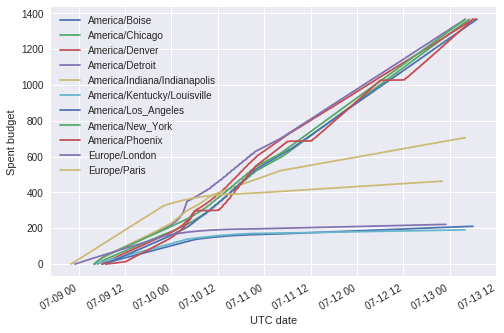

In [59]:
pacing_results.groupby(pacing_results.tz).spent.plot()
plt.legend()
plt.xlabel('UTC date')
plt.ylabel('Spent budget')